<a href="https://colab.research.google.com/github/KaziJahidurRahaman/miscs_reports/blob/main/Time_efficient_ts_data_extraction_onGEE_Python_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time efficient timeseries data extraction on Google Earth Engine Python API

This file holds the code for the medium article <b> Time efficient timeseries data extraction on Google Earth Engine Python API. </b>

In [12]:
# Import the necesarry libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geemap as emap
from datetime import datetime
import ee

# Trigger GEE
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=rmlgxHpLnzk7n03h6Bs5VRVGXfUGX3_tjtcVOie0OSg&tc=YWoeNfXAH_fTK4uCZJtCapTNIJCWVOnbK4znegelBww&cc=i0N3rA7-H6LxoafUSGfy0Z2eZni8P8aIvgwqXg_yiQo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXk4Z-CMRo-Gu314hIJQvkhZ3CRtvgP6AZp9CUISywLKFvpNx3K4cTM

Successfully saved authorization token.


In [13]:
# Area of interest, somewhere near Berlin, Germany
roi = ee.Geometry.Rectangle([13.7828066313537398, 52.3817774379818601,
                            13.8154296884080576, 52.4099122039370400])
start_date = '2014-01-01'
end_date = '2021-12-31'

# Always better to filter the dataset as finer as possible
collectionS1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filterMetadata('resolution_meters', 'equals', 10)\
    .filterBounds(roi).filterDate(start_date, end_date)


# Filter for ascending orbit images
filtered_collection_2014_2021 = collectionS1.filterMetadata('orbitProperties_pass', 'equals', 'ASCENDING')
# Sort the filtered collection by date in ascending order
sorted_collection_2014_2021 = filtered_collection_2014_2021.sort('system:time_start')

# create interactive map for visual representations
Map = emap.Map()
# Add the ROI to the map
Map.addLayer(sorted_collection_2014_2021.first().select('VV'), {'min': -25, 'max': 5}, 'Collection First Image')
Map.addLayer(roi, {}, 'ROI Bounding Box')
Map.addLayerControl()
# Center the map on the ROI
Map.centerObject(roi, 12)  # You can adjust the zoom level (12 in this case)
Map

Map(center=[52.39584444865192, 13.79911815987345], controls=(WidgetControl(options=['position', 'transparent_b…

## Time Series Data Extraction: Time-Consuming Approach

Processed Images: 374
Starting time: 20231015103330
Ending time: 20231015103716
Elapsed time:0:03:45.522433 Hours


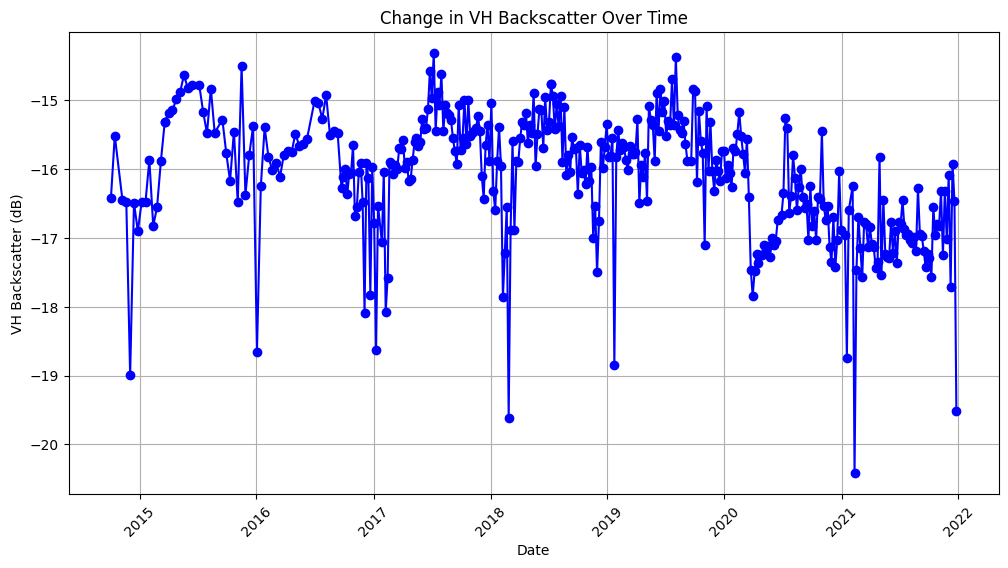

In [14]:
# Initialize empty lists to store dates and backscatter values
time_start = datetime.now()
dates = []
backscatter_values = []

# Iterate through the sorted collection
for image in sorted_collection_2014_2021.toList(sorted_collection_2014_2021.size()).getInfo():
 # Convert the image object to an Earth Engine image
 ee_image = ee.Image(image['id'])

 # Get the acquisition date as a string
 date_str = ee_image.get('system:time_start').getInfo()

 # Parse the string date into a Python datetime object
 acquisition_date = datetime.utcfromtimestamp(int(date_str) // 1000)
 dates.append(acquisition_date)

 # Get the VH band from the image
 vh_band = ee_image.select('VH')

 # Calculate the mean backscatter value within the ROI
 stats = vh_band.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=10)
 backscatter_value = stats.get('VH').getInfo()
 backscatter_values.append(backscatter_value)

# Create a DataFrame to store the data
data = {'Date': dates, 'VH Backscatter': backscatter_values}
df = pd.DataFrame(data)

# Plot the VH backscatter values over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['VH Backscatter'], marker='o', linestyle='-', color='b')
plt.title('Change in VH Backscatter Over Time')
plt.xlabel('Date')
plt.ylabel('VH Backscatter (dB)')
plt.grid(True)
plt.xticks(rotation=45)

time_end = datetime.now()
print(f'Processed Images: {sorted_collection_2014_2021.size().getInfo()}')
print(f'Starting time: {time_start.strftime("%Y%m%d%H%M%S")}')
print(f'Ending time: {time_end.strftime("%Y%m%d%H%M%S")}')
print(f'Elapsed time:{time_end- time_start} Hours')
plt.show()

## Time Series Data Extraction: Time-Efficient Approach

Processed Images: 374
Starting time: 20231015103717
Ending time: 20231015103719
Elapsed time:0:00:02.547830 Hours


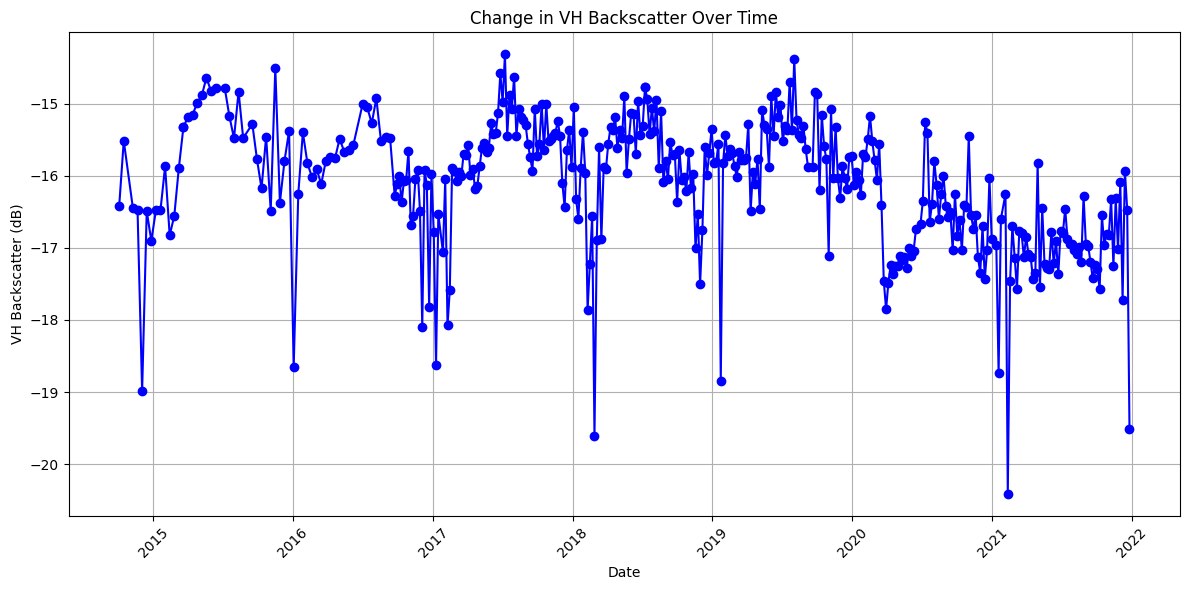

In [15]:
time_start = datetime.now()

def datedist(img):
 img = ee.Image(img)
 date = img.get('system:time_start')

 vh_band = img.select('VH')
 stats = vh_band.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=10)
 backscatter_value = stats.get('VH')
 return img.set('DateDist', date).set('backscatter', backscatter_value)

# Map the function to the image collection
sorted_collection_2014_2021_changed = sorted_collection_2014_2021.map(datedist)

# Use aggregate_array to get the 'DateDist' values as an array
dates_array = sorted_collection_2014_2021_changed.aggregate_array('DateDist')

# Use aggregate_array to get the 'DateDist' values as an array
backscatter_array = sorted_collection_2014_2021_changed.aggregate_array('backscatter')

# Convert the array to a list using getInfo()
dates_list = dates_array.getInfo()
backscatter_list = backscatter_array.getInfo()
string_timestamps = [datetime.utcfromtimestamp(int(date_str) // 1000) for date_str in dates_list]

# Create a DataFrame to store the data
data = {'Date': string_timestamps, 'VH Backscatter': backscatter_list}
df = pd.DataFrame(data)

# Plot the VH backscatter values over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['VH Backscatter'], marker='o', linestyle='-', color='b')
plt.title('Change in VH Backscatter Over Time')
plt.xlabel('Date')
plt.ylabel('VH Backscatter (dB)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

time_end = datetime.now()
print(f'Processed Images: {sorted_collection_2014_2021.size().getInfo()}')
print(f'Starting time: {time_start.strftime("%Y%m%d%H%M%S")}')
print(f'Ending time: {time_end.strftime("%Y%m%d%H%M%S")}')
print(f'Elapsed time:{time_end- time_start} Hours')
plt.show()